### import

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding, ReLU, Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.utils import class_weight

# Tools for saving and loading tokenizer
import pickle

# TensorFlow and Keras callbacks
import tensorflow as tf
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Other utility tools
from string import punctuation
from collections import defaultdict
from typing import List, Dict
import json

### load data

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

load clean data

In [6]:
# load data
df = pd.read_csv('C:\Data\KULIAH\skripsi\model\eksperimen\dataset.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text        10000 non-null  object 
 1   label       10000 non-null  float64
 2   clean_text  10000 non-null  object 
dtypes: float64(1), object(2)
memory usage: 234.5+ KB


,text,label,clean_text
0,endorse sapatu aja pak,0.0,"['endorse', 'sapatu', 'aja', 'pak']"
1,ayo parak sudah,0.0,"['ayo', 'parak', 'sudah']"
2,nang kaini pang kada tau apa apa lalu ditangkap,0.0,"['nang', 'kaini', 'pang', 'kada', 'tau', 'apa'..."
3,oh ini kah gawiannya,0.0,"['oh', 'ini', 'kah', 'gawiannya']"
4,semoga peraturannya bisa direvisi,0.0,"['semoga', 'peraturannya', 'bisa', 'direvisi']"


### data normalisasi

In [4]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
     u"\U0001F600-\U0001F64F" # emoticons
     u"\U0001F300-\U0001F5FF" # symbols & pictographs
     u"\U0001F680-\U0001F6FF" # transport & map symbols
     u"\U0001F1E0-\U0001F1FF" # flags (iOS)
     u"\U00002702-\U000027B0" # symbols
     u"\U000024C2-\U0001F251" # pictographs
     u"\U0001F900-\U0001F9FF" # Supplemental Symbol & Pictograph
     u"\U0001F1F2-\U0001F1F4" # Enclosed Characters
     u"\U0001F1E6-\U0001F1FF" # Regional Indicator Symbols
     u"\U0001F600-\U0001F636" # Emoticons
     u"\U0001F681-\U0001F6C5" # Transport and Map Symbols
     u"\U0001F30D-\U0001F567" # Miscellaneous Symbol& Pictograph
     u"\U0001F680-\U0001F6C0" # Transport and Map Symbols
     u"\U0001F600-\U0001F64F" # Emoticons
     u"\U0001F300-\U0001F5FF" # Symbols & Pictographs
     u"\U0001F680-\U0001F6FF" # Transport & Map Symbols
     u"\U0001F1E0-\U0001F1FF" # Flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    # 4. Remove emojis
    no_emojis = remove_emoji(lowercase_letters)
    return no_emojis


def load_lexical_dict(filepath: str) -> Dict[str, List[str]]:
    with open(filepath, 'r', encoding='utf-8') as file:
        lexical_dict = json.load(file)
    return lexical_dict

def lexical(tokens: List[str], lexical_dict: Dict[str, List[str]]) -> List[str]:
    lexical_tokens = []
    for token in tokens:
        # Cari token dalam kamus
        found = False
        for key, variations in lexical_dict.items():
            if token in variations:
                lexical_tokens.append(key)
                found = True
                break
        if not found:
            lexical_tokens.append(token)
    return lexical_tokens


def lemmatize(tokens: List[str]) -> List[str]:
    # 1. Lemmatize
    tokens = [stemmer.stem(token) for token in tokens]
    # 2. Remove stop words
    meaningful_words = [word for word in tokens if word not in stop_words]
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. remove lexical variation
    lexical_tokens = lexical(tokens, lexical_dict)
    # 4. Lemmatize
    lemmas = lemmatize(lexical_tokens)
    return lexical_tokens

In [5]:
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("indonesian")) 
custom_stopwords = set(['yg', 'dgn', 'dg', 'nya', 'sagan', 'ada', 'adalah', 
                  'adanya', 'adaha', 'unda', 'undaja', 'banar', 'ikam', 
                  'keini', 'kaya', 'kayaitu', 'balum', 'bujur', 'bujurkah', 
                  'bujurlah', 'ampih', 'barapa', 'baarti', 'pamulaan', 'bari', 
                  'barii', 'basiap', 'besiap', 'batakun', 'betakun', 'baurutan', 
                  'baucap', 'lain', 'nang', 'atawa', 'sudahai', 'sesala', 'sasala', 
                  'pahadangan', 'dahulu', 'ampat', 'inya', 'uma', 'umpat', 
                  'handak', 'handakkah', 'ngini', 'nginikah', 'jua', 'wayah', 'amun', 
                  'ikm', 'ikam', 'nyw', 'bedua', 'badua', 'kaluar', 'kena', 'labih', 
                  'kekaya', 'nangkaya', 'ampih', 'nang'
                  'haja', 'pang', 'mun', 'wan', 'lawan', 'kaitu', 
                  'ai', 'ae', 'pulang', 'kalo', 'kawa', 'kaini', 'tu', 'ja', 'ni',
                  'aja', 'kah', 'tuh', 'lo', 'gin', 'tagal'])
stop_words = stop_words.union(custom_stopwords)
factory = StemmerFactory()
stemmer = factory.create_stemmer()
lexical_dict_filepath = 'C:\Data\KULIAH\skripsi\model\eksperimen\pengujian\lexical.json'
lexical_dict = load_lexical_dict(lexical_dict_filepath)

In [ ]:
# preprocess the training data
df['norm'] = df['text'].apply(lambda x: preprocess(x, len(df)))
counter = 0

In [8]:
# mengganti nama column 'clean_text' menjadi 'non_norm'
df = df.rename(columns = {'clean_text':'non_norm'})
df.head()

,text,label,non_norm,norm
0,endorse sapatu aja pak,0.0,"['endorse', 'sapatu', 'aja', 'pak']","[endorse, sapatu, aja, pak]"
1,ayo parak sudah,0.0,"['ayo', 'parak', 'sudah']","[ayo, parak, sudah]"
2,nang kaini pang kada tau apa apa lalu ditangkap,0.0,"['nang', 'kaini', 'pang', 'kada', 'tau', 'apa'...","[nang, kaini, pang, kada, tau, apa, apa, lalu,..."
3,oh ini kah gawiannya,0.0,"['oh', 'ini', 'kah', 'gawiannya']","[oh, ini, kah, gawiannya]"
4,semoga peraturannya bisa direvisi,0.0,"['semoga', 'peraturannya', 'bisa', 'direvisi']","[semoga, peraturannya, bisa, direvisi]"


In [14]:
df = pd.read_csv(r'C:\Data\KULIAH\skripsi\model\eksperimen\fix\dataset.csv')

In [34]:
train_data, text_data = train_test_split(df, test_size=0.2, random_state=32)

In [35]:
train_data.head()

,text,label,non_norm,norm
4004,kalu katulahan ling ae,0.0,"['kalu', 'katulahan', 'ling', 'ae']","['kalu', 'katulahan', 'ling', 'ai']"
9121,lagi berusaha sehat di negara yang garing,1.0,"['lagi', 'berusaha', 'sehat', 'di', 'negara', ...","['lagi', 'berusaha', 'sehat', 'di', 'negara', ..."
1800,tolong lah satu alfamart lawan satu indomaret ...,0.0,"['tolong', 'lah', 'satu', 'alfamart', 'lawan',...","['tulung', 'lah', 'satu', 'alfamart', 'lawan',..."
1081,kok bisa kaya itu,0.0,"['kok', 'bisa', 'kaya', 'itu']","['kok', 'bisa', 'kaya', 'itu']"
8230,menyupani,1.0,['menyupani'],['menyupani']


Processed using only tokenize, belum normalize data

In [36]:
def process_data(train_data, test_data, text_column, label_column, tokenizer_path='tokenizer.pickle'):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_data[text_column])
    
    # Convert texts to sequences
    x_train_sequences = tokenizer.texts_to_sequences(train_data[text_column])
    x_test_sequences = tokenizer.texts_to_sequences(test_data[text_column])
    
    # Pad the sequences to ensure equal length
    x_train = pad_sequences(x_train_sequences, maxlen=50)
    x_test = pad_sequences(x_test_sequences, maxlen=50)
    
    y_train = np.array(train_data[label_column])
    y_test = np.array(test_data[label_column])
    
    # Save the tokenizer
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return x_train, x_test, y_train, y_test

In [37]:
x_train1, x_test1, y_train1, y_test1 = process_data(train_data1, test_data1, 'norm', 'label', tokenizer_path='tokenizer_norm.pickle')

In [38]:
x_train2, x_test2, y_train2, y_test2 = process_data(train_data2, test_data2, 'non_norm', 'label', tokenizer_path='tokenizer_non_norm.pickle')

### model

In [22]:
class Attention(Layer):
    def __init__(self, regularizer=None, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.regularizer = regularizer

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], input_shape[-1]), 
                                 initializer='glorot_uniform', 
                                 trainable=True, 
                                 regularizer=self.regularizer)
        self.b = self.add_weight(name='attention_bias', 
                                 shape=(input_shape[-1],), 
                                 initializer='zeros', 
                                 trainable=True, 
                                 regularizer=self.regularizer)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = tf.reduce_sum(x * a, axis=1)
        return output

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({"regularizer": self.regularizer})
        return config


def get_bilstm_model(vocab_size, input_length, num_features, lstm_units=[32,16], dropout=0.2, recurrent_dropout=0.2, embeddings_weight=None, weight_trainable=True):
    model = Sequential()
    if embeddings_weight is not None:
        model.add(Embedding(vocab_size,
                            num_features,
                            input_length=input_length,
                            weights=[embeddings_weight],
                            trainable=weight_trainable))
    else:
        model.add(Embedding(vocab_size, num_features, input_length=input_length))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(lstm_units[0], return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    model.add(Bidirectional(LSTM(lstm_units[1], return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    model.add(Attention(regularizer=regularizers.l2(0.7)))
    model.add(ReLU())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

## training

### model training

In [23]:
def train_model(model, x_train, y_train, x_test, y_test, x_val=None, y_val=None, set_batch_size=64, num_epochs=6, verbose=False, scale_loss=False):

    # Stop if the model overfits...
    stop = EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=5
    )
    # Save model logs during training to the specific folder
    checkpoint= ModelCheckpoint(
        filepath='./',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    # Lets specify some weights for our class function
    # since the dataset is not really balanced and may cause overfitting
    class_weights = None
    if scale_loss is True:
        pass;

    # training the model
    history = model.fit(x_train,
                        y_train,
                        validation_split=0.2,
                        class_weight=class_weights,
                        epochs=num_epochs,
                        batch_size=set_batch_size,
                        callbacks=[tensorboard_callback, stop, checkpoint])
    # Visualizing training accuracy and loss per epoch to eliminate the potential threat of overfitting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['accuracy'], 'b', label='training acc')
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['val_accuracy'], 'c', label='val acc')
    plt.title('Accuracy Plot')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['loss'], 'r', label='training loss')
    plt.plot(np.arange(len(history.history['accuracy'])), history.history['val_loss'], 'g', label='val loss')
    plt.legend(loc='best')
    plt.title('Loss Plot')
    plt.ylabel('Error/Loss')
    plt.xlabel('Epochs')
    plt.show()
    # train accuracy
    train_acc = model.evaluate(x_train, y_train)
    # Evaluate the model on the test set and check the accuracy
    evaluation = model.evaluate(x_test, y_test)
    # predicting and getting accuracy
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5)
    # y_pred = [1 if prob==True else 0 for prob in y_pred]
    print(classification_report(y_test, y_pred))
    precision_bi, recall_bi, fscore_bi, support_bi = precision_recall_fscore_support(y_test, y_pred)
    print('\nAccuracy', accuracy_score(y_test,y_pred))
    print('BiLSTM: non hate - hate')
    print('precision: {}'.format(precision_bi))
    print('recall: {}'.format(recall_bi))
    print('fscore: {}'.format(fscore_bi))
    print('support: {}'.format(support_bi))
    # getting confusion matrix
    print('\nConfusion Matrix: \n', confusion_matrix(y_test,y_pred))
    if verbose == True:
        # Only open tensorboard if specified so
        %load_ext tensorboard
        %tensorboard --logdir logs
    return model, history

### word embedd

In [39]:
# from string import punctuation
# from collections import defaultdict
def get_vocab(data):
    # Processing
    vocab, reverse_vocab = {}, {}
    freq = defaultdict(int)
    vocab_index = 1
    for text in data:
        for word in text:
            if word not in vocab:
                vocab[word] = vocab_index
                reverse_vocab[vocab_index] = word       # generate reverse vocab as well
                vocab_index += 1
            freq[word] += 1
    vocab['UNK'] = len(vocab) + 1
    reverse_vocab[len(vocab)] = 'UNK'
    return vocab, reverse_vocab, freq

### embedding normalisasi

In [40]:
vocabulary1, reverse_vocabulary1, frequencies1 = get_vocab(train_data['norm'])

In [41]:
# define training data
sentences1 = train_data['norm'].apply(str.split).tolist()  # memastikan kalimat dalam bentuk daftar kata

# train model
w2v_model1 = Word2Vec(sentences1, vector_size=64, window=4, min_count=1, sg=1)

# Define our vocabulary as words
words1 = list(w2v_model1.wv.index_to_key)
vocab_size1 = len(words1)
print('Vocabulary Size: ', vocab_size1)

# Define our embedding matrix to be set as weight of the w2v_model Embedding Layer
embedding_matrix1 = np.zeros((vocab_size1, 64))
for i in range(0, len(words1)):
    embedding_vector1 = w2v_model1.wv[words1[i]]
    if embedding_vector1 is not None:
        embedding_matrix1[i] = embedding_vector1

# Add random vectors for padding (if necessary)
embedding_matrix1[vocab_size1-1] = np.random.normal(scale=0.6, size=(64,))

Vocabulary Size:  14830


### embedding non-normalisasi

In [42]:
vocabulary2, reverse_vocabulary2, frequencies2 = get_vocab(train_data['non_norm'])

In [43]:
# define training data
sentences2 = train_data['non_norm'].apply(str.split).tolist()  # memastikan kalimat dalam bentuk daftar kata

# train model
w2v_model2 = Word2Vec(sentences2, vector_size=64, window=4, min_count=1, sg=1)

# Define our vocabulary as words
words2 = list(w2v_model2.wv.index_to_key)
vocab_size2 = len(words2)
print('Vocabulary Size: ', vocab_size2)

# Define our embedding matrix to be set as weight of the w2v_model Embedding Layer
embedding_matrix2 = np.zeros((vocab_size2, 64))
for i in range(0, len(words2)):
    embedding_vector2 = w2v_model2.wv[words2[i]]
    if embedding_vector2 is not None:
        embedding_matrix2[i] = embedding_vector2

# Add random vectors for padding (if necessary)
embedding_matrix2[vocab_size2-1] = np.random.normal(scale=0.6, size=(64,))

Vocabulary Size:  14929


### Training

In [44]:
bilstm_model1 = get_bilstm_model(vocab_size1, 50, 64, [64, 32], dropout=0.2, recurrent_dropout=0.2, embeddings_weight=embedding_matrix1, weight_trainable=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 64)            949120    
                                                                 
 dropout_4 (Dropout)         (None, 50, 64)            0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 50, 128)           66048     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 50, 64)            41216     
 onal)                                                           
                                                                 
 attention_2 (Attention)     (None, 64)                4160      
                                                                 
 re_lu_2 (ReLU)              (None, 64)               

Epoch 1/8
100/100 [==============================] - 98s 829ms/step - loss: 24.0460 - accuracy: 0.5053 - val_loss: 10.0439 - val_accuracy: 0.5275
Epoch 2/8
100/100 [==============================] - 76s 763ms/step - loss: 5.1143 - accuracy: 0.5231 - val_loss: 2.1815 - val_accuracy: 0.5487
Epoch 3/8
100/100 [==============================] - 75s 751ms/step - loss: 1.2603 - accuracy: 0.6406 - val_loss: 0.6583 - val_accuracy: 0.7631
Epoch 4/8
100/100 [==============================] - 74s 745ms/step - loss: 0.4090 - accuracy: 0.8633 - val_loss: 0.3799 - val_accuracy: 0.8562
Epoch 5/8
100/100 [==============================] - 75s 753ms/step - loss: 0.2302 - accuracy: 0.9169 - val_loss: 0.3957 - val_accuracy: 0.8425
Epoch 6/8
100/100 [==============================] - 76s 766ms/step - loss: 0.1618 - accuracy: 0.9417 - val_loss: 0.3643 - val_accuracy: 0.8644
Epoch 7/8
100/100 [==============================] - 76s 756ms/step - loss: 0.1185 - accuracy: 0.9619 - val_loss: 0.3685 - val_accurac

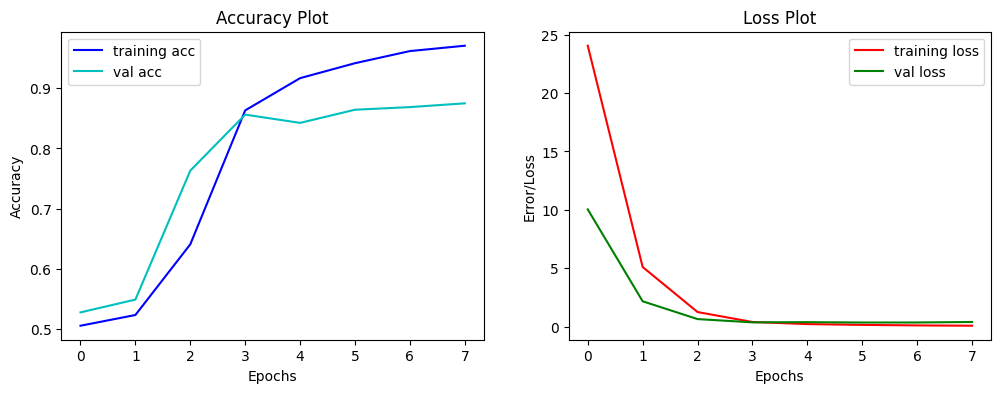

63/63 [==============================] - 4s 29ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1012
         1.0       0.89      0.86      0.87       988

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000


Accuracy 0.8765
BiLSTM: non hate - hate
precision: [0.86463298 0.88958991]
recall: [0.89624506 0.8562753 ]
fscore: [0.88015526 0.87261475]
support: [1012  988]

Confusion Matrix: 
 [[907 105]
 [142 846]]
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10672), started 0:14:52 ago. (Use '!kill 10672' to kill it.)

In [45]:
trained_model1, history1 = train_model(bilstm_model1, x_train1, y_train1, x_test1, y_test1, num_epochs=8, set_batch_size=64, verbose=True)

In [46]:
bilstm_model2 = get_bilstm_model(vocab_size2, 50, 64, [64, 32], dropout=0.2, recurrent_dropout=0.2, embeddings_weight=embedding_matrix2, weight_trainable=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 64)            955456    
                                                                 
 dropout_6 (Dropout)         (None, 50, 64)            0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 50, 128)           66048     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 50, 64)            41216     
 onal)                                                           
                                                                 
 attention_3 (Attention)     (None, 64)                4160      
                                                                 
 re_lu_3 (ReLU)              (None, 64)               

Epoch 1/8
100/100 [==============================] - 88s 743ms/step - loss: 24.2344 - accuracy: 0.5138 - val_loss: 10.1975 - val_accuracy: 0.5038
Epoch 2/8
100/100 [==============================] - 73s 727ms/step - loss: 5.1845 - accuracy: 0.5758 - val_loss: 2.1831 - val_accuracy: 0.6212
Epoch 3/8
100/100 [==============================] - 76s 764ms/step - loss: 1.2645 - accuracy: 0.6809 - val_loss: 0.7074 - val_accuracy: 0.7788
Epoch 4/8
100/100 [==============================] - 70s 704ms/step - loss: 0.5940 - accuracy: 0.7655 - val_loss: 0.5056 - val_accuracy: 0.7937
Epoch 5/8
100/100 [==============================] - 74s 741ms/step - loss: 0.4716 - accuracy: 0.7819 - val_loss: 0.4524 - val_accuracy: 0.7806
Epoch 6/8
100/100 [==============================] - 74s 743ms/step - loss: 0.3779 - accuracy: 0.8344 - val_loss: 0.4791 - val_accuracy: 0.8056
Epoch 7/8
100/100 [==============================] - 73s 733ms/step - loss: 0.2660 - accuracy: 0.8955 - val_loss: 0.4248 - val_accurac

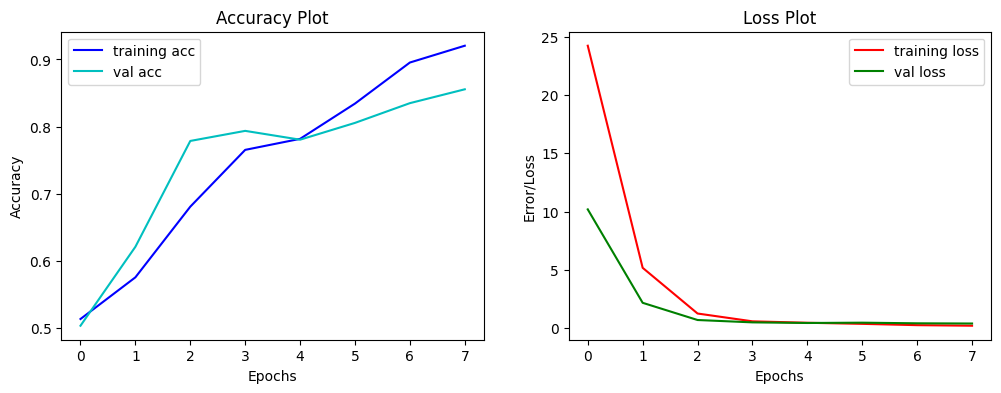

63/63 [==============================] - 9s 110ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85      1012
         1.0       0.85      0.86      0.85       988

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000


Accuracy 0.8525
BiLSTM: non hate - hate
precision: [0.85885886 0.84615385]
recall: [0.84782609 0.85728745]
fscore: [0.85330681 0.85168426]
support: [1012  988]

Confusion Matrix: 
 [[858 154]
 [141 847]]
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10672), started 0:25:42 ago. (Use '!kill 10672' to kill it.)

In [47]:
trained_model2, history2 = train_model(bilstm_model2, x_train2, y_train2, x_test2, y_test2, num_epochs=8, set_batch_size=64, verbose=True)

### check

In [59]:
def convert_to_text(tokenizer, sequences):
    # Convert sequences back to text
    reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}
    text_sequences = []
    for sequence in sequences:
        text_sequence = ' '.join([reverse_word_index.get(word, '') for word in sequence if word != 0])
        text_sequences.append(text_sequence)
    return text_sequences

# Assuming you have the tokenizer loaded from the pickle file
with open('tokenizer_norm.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

# Convert x_test back to text
x_test_text = convert_to_text(loaded_tokenizer, x_test1)

In [49]:
x_test_text[:5]

["'sariki' 'pak' 'ai' 'mahir' 'gawian' 'asal' 'asalan' 'asal' 'tuntung' 'dananya' 'milyaran' 'ditelusuri' 'kamana' 'dananya' 'nang' 'banyak' 'tuh' 'mangalir' 'pariksa' 'buhan' 'pihak' 'terkait' 'jangan' 'jangan' 'diambil' 'ngalihai' 'mun' 'masalah' 'duit' 'milyaran' 'nang' 'ini' 'habang' 'hijau' 'mata' 'malihat'",
 "'asa' 'sedih' 'hati' 'malihat' 'bapa' 'ibu' 'nang' 'ikut' 'serta' 'pembangunan' 'masih' 'haja' 'kada' 'kawa' 'nukar' 'baras'",
 "'korupsi'",
 "'amun' 'puasa' 'kadada' 'cobaanya' 'kaya' 'apa' 'handak' 'dapat' 'pahala' 'tambahan' 'wey'",
 "'sarik' 'banaran' 'sidin' 'debest' 'dah' 'pian' 'pak' 'ay' 'selalu' 'jadi' 'favorit' 'ulun'"]

In [60]:
# buat dataframe dari x_test1 dan y_test1
pred = pd.DataFrame(x_test_text, columns=['text'])
pred['label'] = y_test1
pred['label_pred'] = trained_model9.predict(x_test1)

63/63 [==============================] - 1s 15ms/step


In [51]:
pred.head()

,text,label,label_pred
0,'sariki' 'pak' 'ai' 'mahir' 'gawian' 'asal' 'a...,1.0,0.961074
1,'asa' 'sedih' 'hati' 'malihat' 'bapa' 'ibu' 'n...,0.0,0.010862
2,'korupsi',0.0,0.237784
3,'amun' 'puasa' 'kadada' 'cobaanya' 'kaya' 'apa...,0.0,0.022250
4,'sarik' 'banaran' 'sidin' 'debest' 'dah' 'pian...,0.0,0.011855


In [61]:
pred['label_pred'] = pred['label_pred'].apply(lambda x: 1 if x >= 0.5 else 0)

In [62]:
pred.to_csv(r'C:\Data\KULIAH\skripsi\model\eksperimen\fix\prediksi_norm.csv', index=False)

In [63]:
# Assuming you have the tokenizer loaded from the pickle file
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer2 = pickle.load(handle)

# Convert x_test back to text
x_test_nonnorm_text = convert_to_text(loaded_tokenizer2, x_test2)

In [64]:
pred2 = pd.DataFrame(x_test_nonnorm_text, columns=['text'])
pred2['label'] = y_test2
pred2['label_pred'] = trained_model10.predict(x_test2)
pred2['label_pred'] = pred2['label_pred'].apply(lambda x: 1 if x >= 0.5 else 0)

63/63 [==============================] - 1s 16ms/step


In [65]:
pred2.head()

,text,label,label_pred
0,'sariki' 'pak' 'ai' 'mahir' 'gawian' 'asal' 'a...,1.0,1
1,'asa' 'sedih' 'hati' 'malihat' 'bapa' 'ibu' 'n...,0.0,0
2,'korupsi',0.0,0
3,'amun' 'puasa' 'kadada' 'cobaanya' 'kaya' 'apa...,0.0,0
4,'sarik' 'banaran' 'sidin' 'debest' 'dah' 'pian...,0.0,0


In [66]:
pred2.to_csv(r'C:\Data\KULIAH\skripsi\model\eksperimen\fix\prediksi_non_norm.csv', index=False)

### bagian training

In [67]:
x_train_norm_text = convert_to_text(loaded_tokenizer, x_train1)
x_train_nonnorm_text = convert_to_text(loaded_tokenizer2, x_train2)

In [68]:
acc = pd.DataFrame(x_train_norm_text, columns=['text'])
acc['label'] = y_train1
acc['label_pred'] = trained_model9.predict(x_train1)
acc['label_pred'] = acc['label_pred'].apply(lambda x: 1 if x >= 0.5 else 0)
acc.to_csv(r'C:\Data\KULIAH\skripsi\model\eksperimen\fix\acc_norm.csv', index=False)

250/250 [==============================] - 4s 16ms/step


In [69]:
acc.head()

,text,label,label_pred
0,'kadada' 'gunanya' 'polisi' 'kadada' 'baguna',1.0,1
1,'itulah' 'pak' 'negri' 'kita' 'proyeknya' 'di'...,0.0,0
2,'bagaimana' 'tanggapan' 'pian' 'nang' 'urang' ...,0.0,0
3,'kakanak' 'babungulan' 'kaini' 'rupanya' 'kaya...,1.0,1
4,'kanyang' 'sawa' 'dapatnya' 'duit' 'rayat' 'iy...,1.0,1


In [70]:
acc2 = pd.DataFrame(x_train_nonnorm_text, columns=['text'])
acc2['label'] = y_train2
acc2['label_pred'] = trained_model10.predict(x_train2)
acc2['label_pred'] = acc2['label_pred'].apply(lambda x: 1 if x >= 0.5 else 0)
acc2.to_csv(r'C:\Data\KULIAH\skripsi\model\eksperimen\fix\acc_non_norm.csv', index=False)

250/250 [==============================] - 4s 16ms/step


In [71]:
acc2.head()

,text,label,label_pred
0,'kadada' 'gunanya' 'polisi' 'kadada' 'baguna',1.0,1
1,'itulah' 'pak' 'negri' 'kita' 'proyeknya' 'di'...,0.0,0
2,'bagaimana' 'tanggapan' 'pian' 'nang' 'urang' ...,0.0,0
3,'kakanak' 'babungulan' 'kaini' 'rupanya' 'kaya...,1.0,1
4,'kanyang' 'sawa' 'dapatnya' 'duit' 'rayat' 'iy...,1.0,1


### implementasi

In [ ]:
# Save the model
trained_model9.save('model_norm.h5')
trained_model10.save('model_non_norm.h5')

In [77]:
# implementasi ke sistem
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

def load_tokenizer(tokenizer_path):
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    return tokenizer

def load_custom_model(model_path):
    with tf.keras.utils.custom_object_scope({'Attention': Attention, 'L2': regularizers.l2}):
        model = load_model(model_path)
    return model


def predict_hate_speech(text, model, tokenizer, max_length=50):
    # Clean the text
    text = preprocess(text, 1, show_progress=False)
    # Tokenize the text
    text = tokenizer.texts_to_sequences(text)
    # Pad the sequence
    text = pad_sequences(text, maxlen=max_length)
    # Predict the sentiment
    prediction = model.predict(text)
    return prediction

tokenizer_norm = load_tokenizer('tokenizer_norm.pickle')
model_norm = load_custom_model('model_norm.h5')

# tokenizer_non_norm = load_tokenizer('tokenizer_non_norm.pickle')
# model_non_norm = load_model('model_non_norm.h5')

In [78]:
text = 'kada bautak'
prediction = predict_hate_speech(text, model_norm, tokenizer_norm)
print('Prediction: ', prediction)

1/1 [==============================] - 2s 2s/step
Prediction:  [[0.15767491]
 [0.15767491]]


In [79]:
text = 'bakantan kada waras'
prediction = predict_hate_speech(text, model_norm, tokenizer_norm)
print('Prediction: ', prediction)

1/1 [==============================] - 0s 83ms/step
Prediction:  [[0.15767492]
 [0.15767492]
 [0.15767492]]


In [ ]:
text = 'bungul'
prediction = predict_hate_speech(text, model_non_norm, tokenizer_non_norm)
print('Prediction: ', prediction)

text = 'anjing'
prediction = predict_hate_speech(text, model_norm, tokenizer_norm)

In [86]:
# save model 9
trained_model9.save('C:\Data\KULIAH\skripsi\model\eksperimen\model\model_normalisasi.h5')
trained_model10.save('C:\Data\KULIAH\skripsi\model\eksperimen\model\model_non_normalisasi.h5')

In [87]:
bilstm_model9.save('C:\Data\KULIAH\skripsi\model\eksperimen\pengujian\model_normalisasi.h5')
bilstm_model10.save('C:\Data\KULIAH\skripsi\model\eksperimen\pengujian\model_non_normalisasi.h5')

In [88]:
# save embedding matrix
np.save('C:\Data\KULIAH\skripsi\model\eksperimen\model\embedding_matrix_normalisasi.npy', embedding_matrix1)
np.save('C:\Data\KULIAH\skripsi\model\eksperimen\model\embedding_matrix_non_normalisasi.npy', embedding_matrix2)

In [43]:
# Menyimpan data ke file npz
np.savez('train_test_data_normalisasi.npz', x_train=x_train1, y_train=y_train1, x_test=x_test1, y_test=y_test1)
np.savez('train_test_data_non_normalisasi.npz', x_train=x_train2, y_train=y_train2, x_test=x_test2, y_test=y_test2)

In [21]:
# save tokenizer
import pickle
with open('tokenizer_normalisasi.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'tokenizer' is not defined

In [ ]:
with open('tokenizer_non_normalisasi.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)